#### Import modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import modules.peaks as px
import modules.fouriertransform as ft
import modules.correlationfunctions as cf
import modules.gaussianfield as grf
import modules.filters as flt
import nbodykit.lab as nbkt

/home/jaafar/nbodykit/nbodykit/extern/docrep.py:412: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents(s)
/home/jaafar/nbodykit/nbodykit/extern/docrep.py:341: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


# Gaussian fields

## Set Parameters

In [3]:
N = 256 # Number of particles per side 
BoxSize = 512.0 # Size per side (Mpc)
dx = BoxSize/N
h = 0.695 # Reduced Hubble constant
k0 = 0.02 # Pivot mode
A0 = (7.96*10**-10) # Amplitude
ns = 0.965 # Spectral index
dk = 0.03 # Bin size (for power spectrum)

seed = 13579

Pk = lambda k: A0 * (k/k0)**(ns-1) * k**-3 # Power spectrum

## Generate Gaussian field

To generate a Gaussian random field with a given power spectrum $P(k)$, we can just compute $f_{\mathbf{k}} = \sum \hat a_{\mathbf{k}} \sqrt{P(k)} e^{-i\mathbf{k}.\mathbf{x}}$ where $\hat a_{\mathbf{k}}$ is a Gaussian deviate, and inverse-Fourier transform it.


In [4]:
# Using nbodykit

mesh = nbkt.LinearMesh(Plin=Pk, Nmesh=N, BoxSize=BoxSize, seed=seed)
g = mesh.preview() - 1



In [6]:
# Using gaussianfield

#g = grf.gaussian_random_field(N, BoxSize=N, seed=seed)

/home/jaafar/Desktop/GitHub/modules/gaussianfield.py:18: RuntimeWarning: divide by zero encountered in power
  def gaussian_random_field(N, BoxSize=1.0, seed=None, Pk=lambda k: k**-3):


## Plot a slice of a field

Text(0.5, 1.0, '$\\times 10^{-5}$')

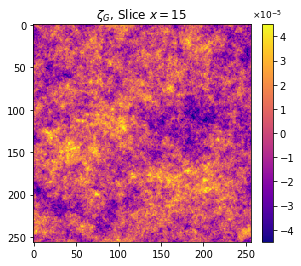

In [4]:
x = 15

plt.figure(figsize=(5, 4))
plt.title(r'$\zeta_G$, Slice $x = $' + str(x))
plt.imshow(10**5*g[x].real, interpolation='none', cmap='plasma', vmin=-4.5, vmax=4.5)
plt.colorbar(fraction=0.046, pad=0.04).ax.set_title(r'$\times 10^{-5}$', fontsize=9)


# Uncorrelated peaks and statistics



## Peaks functions
The peaks we consider here have a shape defined by the function $\texttt{profile}$ in $\texttt{peaks.py}$. For a Gaussian profile: $$P_p (\mathbf{x}) = \frac{Z_p}{(2 \pi R_p^2)^{3/2}} e^{-\frac{\| \mathbf{x} \| ^2}{2R_p^2}}.$$

The (uncorrelated) non-Gaussian field is then: $$\zeta (\mathbf{x}) = \zeta_G (\mathbf{x}) + \sum_{p=1}^{N_{peaks}} P_p (\mathbf{x} - \mathbf{x_p}).$$

We choose a number $N_{peaks}$, uniformly draw, using  the function $\texttt{draw\_peaks}$, $N_{peaks}$ positions on the grid for the peaks, and add their contribution to the Gaussian field.

## Add peaks
Add $\texttt{nop}$ peaks of size $\texttt{R}$ and amplitude $\texttt{zp}$ to the Gaussian realization $\texttt{g}$. 

In [21]:
nop = 50
zp = 25e-5
r = 8

u_peaks = px.draw_peaks(nop, N, zp, r)
ng = px.add_peaks(g, u_peaks, N)


## Plot slices

Text(0.5, 1.0, '$\\times 10^{-5}$')

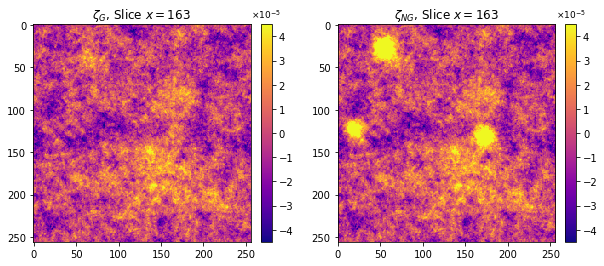

In [8]:
p = 1 # number of the peak
x = u_peaks[p][0][0]

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.title(r'$\zeta_G$, Slice $x = $' + str(x))
plt.imshow(10**5*g[x].real, interpolation='none', cmap='plasma', vmin=-4.5, vmax=4.5)
plt.colorbar(fraction=0.046, pad=0.04).ax.set_title(r'$\times 10^{-5}$', fontsize=9)


plt.subplot(122)
plt.title(r'$\zeta_{NG}$, Slice $x = $' + str(x))
plt.imshow(10**5*ng[x].real, interpolation='none', cmap='plasma', vmin=-4.5, vmax=4.5)
plt.colorbar(fraction=0.046, pad=0.04).ax.set_title(r'$\times 10^{-5}$', fontsize=9)

## Plot power spectrum

Text(0, 0.5, '$k^{4-n_s}P(k)$')

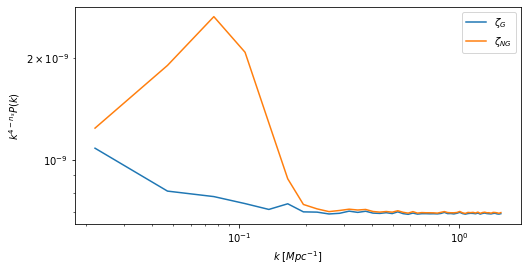

In [10]:
# Using nbodykit

mesh_zeta_G = nbkt.ArrayMesh(g, BoxSize=BoxSize)
r_zeta_G = nbkt.FFTPower(mesh_zeta_G, mode='1d', dk=dk)
power_G = r_zeta_G.power

mesh_zeta_NG = nbkt.ArrayMesh(ng, BoxSize=BoxSize)
r_zeta_NG = nbkt.FFTPower(mesh_zeta_NG, mode='1d', dk=dk)
power_NG = r_zeta_NG.power

k = power_G['k']

plt.figure(figsize=(8, 4))
plt.loglog(k, k**(4-ns)*power_G['power'], label=r'$\zeta_G$')
plt.loglog(k, k**(4-ns)*power_NG['power'], label=r'$\zeta_{NG}$')
plt.legend(loc='upper right')
plt.xlabel(r'$k$ $[Mpc^{-1}]$')
plt.ylabel(r'$k^{4-n_s}P(k)$')

Text(0, 0.5, '$k^{4-n_s}P(k)$')

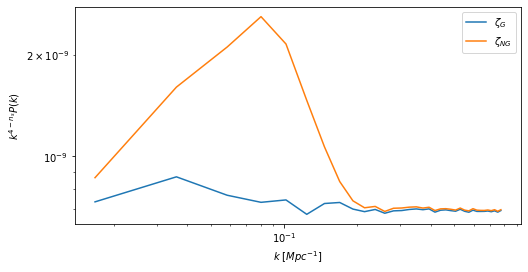

In [13]:
# Using correlationfunction module

pg, k = cf.power_spectrum(g, BoxSize=BoxSize)
png, k = cf.power_spectrum(ng, BoxSize=BoxSize)

pg = pg[k<.5*(N/BoxSize)] # Select modes bellow the Nyquist frequency
png = png[k<.5*(N/BoxSize)]
k = k[k<.5*(N/BoxSize)]


plt.figure(figsize=(8, 4))
plt.loglog(2*k*np.pi, k**(4-ns)*pg, label=r'$\zeta_G$')
plt.loglog(2*k*np.pi, k**(4-ns)*png, label=r'$\zeta_{NG}$')
plt.legend(loc='upper right')
plt.xlabel(r'$k$ $[Mpc^{-1}]$')
plt.ylabel(r'$k^{4-n_s}P(k)$')

## Plot CDF and PDF

(-3.0, 3.0)

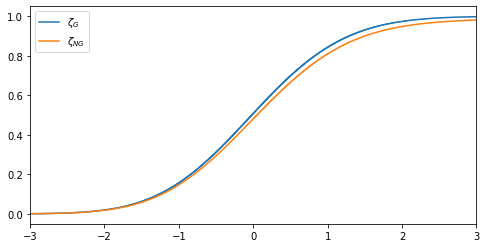

In [15]:
# Plot CDF
s = g.std()
xg, cdfg = cf.cdf(g)
xng, cdfng = cf.cdf(ng)


plt.figure(figsize=(8, 4))

plt.plot(xg/s, cdfg, label=r'$\zeta_G$') #in units of the standard deviation in the x-axis
plt.plot(xng/s, cdfng, label=r'$\zeta_{NG}$') #in units of the standard deviation in the x-axis
plt.legend(loc='upper left')
plt.xlim((-3.0, 3.0))

(-3.0, 3.0)

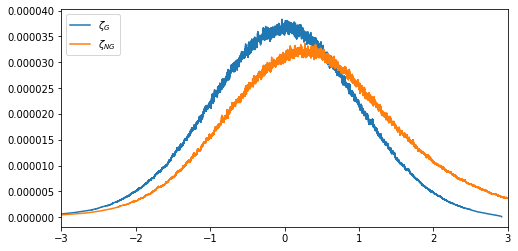

In [22]:
# Plot PDF
s = g.std()
yg, pdfg = cf.pdf(g)                                                                                                                                                                                                                                                                                               
yng, pdfng = cf.pdf(ng)


plt.figure(figsize=(8, 4))

plt.plot(yg/s, pdfg, label=r'$\zeta_G$')
plt.plot(yng/s, pdfng, label=r'$\zeta_{NG}$')
plt.legend(loc='upper left')
plt.xlim((-3.0, 3.0))

## Vary parameters of peaks



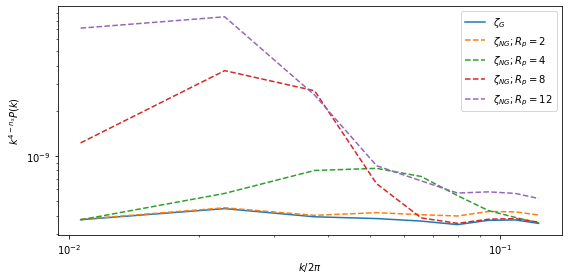

In [11]:
# Variation of the radius r for fixed nop and zp
s = g.std()

R = [2, 4, 8, 12]
nop = 5
zp = 25e-5

c = len(R)



plt.figure(figsize=(8, 4))

pg, k = cf.power_spectrum(g, BoxSize=BoxSize)
pg = pg[k<.5*(N/BoxSize)]
k = k[k<.5*(N/BoxSize)]
plt.loglog(k, pg*k**(4-ns), label=r'$\zeta_G$')

for i in range(c):
    u_peaks = px.draw_peaks(nop, N, zp, R[i])
    ng = px.add_peaks(g, u_peaks, N)
    
    png, k = cf.power_spectrum(ng, BoxSize=BoxSize)
    png = png[k<.5*(N/BoxSize)]
    k = k[k<.5*(N/BoxSize)]
    plt.loglog(k, png * k ** (4-ns), '--', label=r'$\zeta_{NG} ; R_p = $' + str(R[i]))

plt.xlabel(r'$k/2\pi$')
plt.ylabel(r'$k^{4-n_s}P(k)$')
plt.legend(loc='upper right')

plt.tight_layout()

In [29]:
g.std()

1.3376572e-05

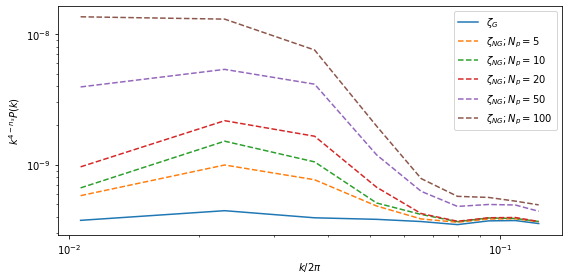

In [14]:
# Variation of the number of peaks nop for fixed r and zp

Np = [5, 10, 20, 50, 100]
zp = 10e-5
rp = 8

np = len(Np)

plt.figure(figsize=(8, 4))

pg, k = cf.power_spectrum(g, BoxSize=BoxSize)
pg = pg[k<.5*(N/BoxSize)]
k = k[k<.5*(N/BoxSize)]
plt.loglog(k, pg* k ** (4-ns), label=r'$\zeta_G$')

for i in range(np):
    u_peaks = px.draw_peaks(Np[i], N, zp, rp)
    ng = px.add_peaks(g, u_peaks, N)
    
    png, k = cf.power_spectrum(ng, BoxSize=BoxSize)
    png = png[k<.5*(N/BoxSize)]
    k = k[k<.5*(N/BoxSize)]
    plt.loglog(k, png * k ** (4-ns), '--', label='$\zeta_{NG} ; N_p = $' + str(Np[i]))
    
plt.xlabel(r'$k/2\pi$')
plt.ylabel(r'$k^{4-n_s}P(k)$')
plt.legend(loc='upper right')




plt.tight_layout()

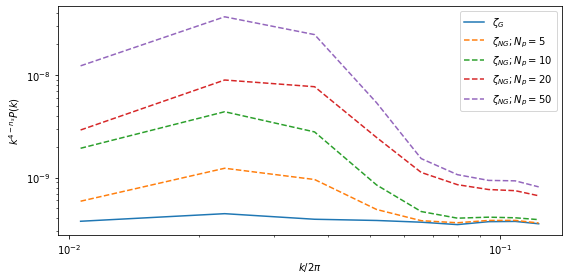

In [17]:
# Variation of the amplitude zp for fixed r and nop

Z = [ 8.5e-5, 20e-5, 30e-5, 60e-5]
z = len(Z)
nop = 10
rp = 8

plt.figure(figsize=(8, 4))

pg = pg[k<.5*(N/BoxSize)]
k = k[k<.5*(N/BoxSize)]
plt.loglog(k, pg* k ** (4-ns), label=r'$\zeta_G$')

for i in range(z):
    u_peaks = px.draw_peaks(nop, N, Z[i], rp)
    ng = px.add_peaks(g, u_peaks, N)

    png, k = cf.power_spectrum(ng, BoxSize=BoxSize)
    png = png[k<.5*(N/BoxSize)]
    k = k[k<.5*(N/BoxSize)]
    plt.loglog(k, png * k ** (4-ns), '--', label='$\zeta_{NG} ; N_p = $' + str(Np[i]))

plt.xlabel(r'$k/2\pi$')
plt.ylabel(r'$k^{4-n_s}P(k)$')
plt.legend(loc='upper right')


plt.tight_layout()

# Correlated peaks and statistics

We apply the following functions on the Gaussian field to generate a non-Gaussian field. The plots are in units of the standard deviation of the Gaussian field

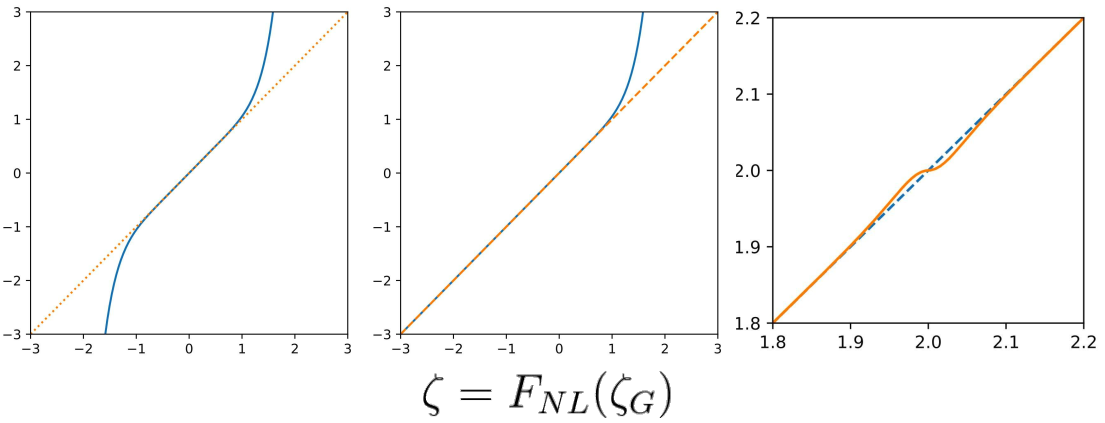

In [19]:
from IPython.display import Image
Image(filename='Plots/fcts.png')

## Set parameters

In [3]:
# NonG Parameters

alpha = 5
nu = 2.7
c, w = 2, .2

In [3]:
# Generate G field using nbodykit

N = 128
BoxSize = 512.0
dx = BoxSize/N
h = 0.695
k0 = 0.02 
A0 = (7.96*10**-10)# * 2*np.pi**2)
ns = 0.965
seed = 13579

Pk = lambda k: A0*(k/k0)**(ns-1)*k**-3
mesh = nbkt.LinearMesh(Plin=Pk, Nmesh=N, BoxSize=BoxSize, seed=seed)
g = mesh.preview() -1

## Generate nonG fields

In [4]:
# Generate nonG fields

s = g.std()

zeta_NG_symsinh = px.map_sinh(g, nu*s, alpha)
zeta_NG_asymsinh = px.map_asymm_sinh(g, nu*s, alpha)
zeta_NG_smooth_bump = px.map_smooth_bump(g, c, w)

/home/jaafar/Desktop/GitHub/modules/peaks.py:6: RuntimeWarning: invalid value encountered in power
  return np.where(x<0, -(-x)**(1/n), x**(1/n)).real


## Power spectrum

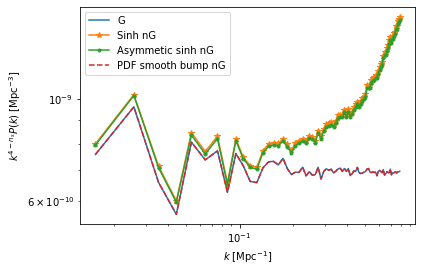

In [51]:
# Using nbodykit

dk = 0.01
kmin = 0.01

# Gaussian

mesh_zeta_G = nbkt.ArrayMesh(g, BoxSize=BoxSize)
r_zeta_G = nbkt.FFTPower(mesh_zeta_G, mode='1d', dk=dk, kmin=kmin)
power_G = r_zeta_G.power

# Sinh nonG

mesh_zeta_NG_symsinh = nbkt.ArrayMesh(zeta_NG_symsinh, BoxSize=BoxSize)
r_zeta_NG_symsinh = nbkt.FFTPower(mesh_zeta_NG_symsinh, mode='1d', dk=dk, kmin=kmin)
power_NG_symsinh = r_zeta_NG_symsinh.power

# Asymmetric sinh nonG

mesh_zeta_NG_asymsinh = nbkt.ArrayMesh(zeta_NG_asymsinh, BoxSize=BoxSize)
r_zeta_NG_asymsinh = nbkt.FFTPower(mesh_zeta_NG_asymsinh, mode='1d', dk=dk, kmin=kmin)
power_NG_asymsinh = r_zeta_NG_asymsinh.power

# PDF smooth bump nonG

mesh_zeta_NG_smooth_bump = nbkt.ArrayMesh(zeta_NG_smooth_bump, BoxSize=BoxSize)
r_zeta_NG_smooth_bump = nbkt.FFTPower(mesh_zeta_NG_smooth_bump, mode='1d', dk=dk, kmin=kmin)
power_NG_smooth_bump = r_zeta_NG_smooth_bump.power


# Plot power spectra

k = power_G['k']
plt.loglog(k, k**(4-ns)*power_G['power'].real, '-', label='G')
plt.loglog(k, k**(4-ns)*power_NG_symsinh['power'].real, '*-', label='Sinh nG')
plt.loglog(k, k**(4-ns)*power_NG_asymsinh['power'].real, '.-', label='Asymmetic sinh nG')
plt.loglog(k, k**(4-ns)*power_NG_smooth_bump['power'].real, '--', label='PDF smooth bump nG')

plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$k^{4-n_s}P(k)$ [Mpc$^{-3}$]')
plt.legend(loc='upper left')


## PDF

In [6]:
N = 128

g = grf.gaussian_random_field(N, BoxSize=N, seed=seed)
g /= g.std()

yg, pdfg = cf.pdf(g)                                                                                                                                                                                                                                                                                               

# NonG Parameters

s = g.std()


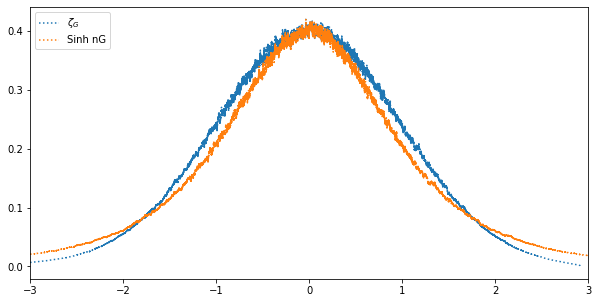

In [7]:
alpha = 1
nu = 1.3

zeta_NG_symsinh = px.map_sinh(g, nu*s, alpha)
yNG_symsinh, pdfNG_symsinh = cf.pdf(zeta_NG_symsinh)

plt.figure(figsize=(10, 5))

plt.plot(yg/s, pdfg, ':', label=r'$\zeta_G$')
plt.plot(yNG_symsinh/s, pdfNG_symsinh, ':', label='Sinh nG')

plt.legend(loc='upper left')
plt.xlim((-3.0, 3.0))

plt.show()

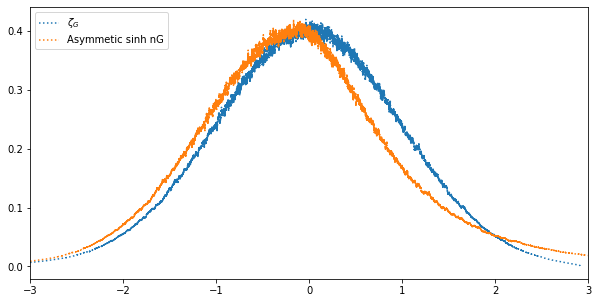

In [9]:
alpha = 1
nu = 1.1

zeta_NG_asymsinh = px.map_asymm_sinh(g, nu*s, alpha)
yNG_asymsinh, pdfNG_asymsinh = cf.pdf(zeta_NG_asymsinh)                                                                                                                                                                                                                                                               

plt.figure(figsize=(10, 5))

plt.plot(yg/s, pdfg, ':', label=r'$\zeta_G$')
plt.plot(yNG_asymsinh/s, pdfNG_asymsinh, ':', label='Asymmetic sinh nG')

plt.legend(loc='upper left')
plt.xlim((-3.0, 3.0))

plt.show()

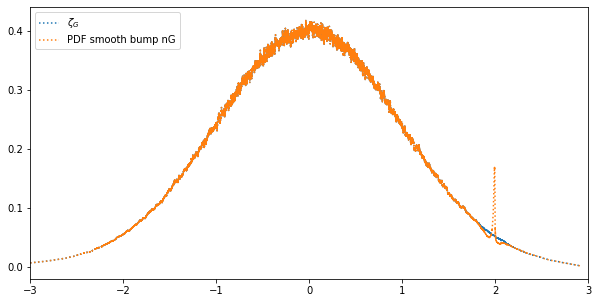

In [12]:
c, w = 2, .05

zeta_NG_smooth_bump = px.map_smooth_bump(g, c*s, w*s)
yNG_smooth_bump, pdfNG_smooth_bump = cf.pdf(zeta_NG_smooth_bump)


plt.figure(figsize=(10, 5))

plt.plot(yg/s, pdfg, ':', label=r'$\zeta_G$')
plt.plot(yNG_smooth_bump/s, pdfNG_smooth_bump, ':', label='PDF smooth bump nG')

plt.legend(loc='upper left')
plt.xlim((-3.0, 3.0))

plt.show()

# Evolve to $\zeta$ to Peak Patch initial density field 
We use $\texttt{CAMB}$ to (linearly) evolve the primordial curvature perturbations to an initial density field at redshift $z=0$. 

## Load and interpolate CAMB transfer function

The $\texttt{CAMB}$ output file contains a list of $k$ and a list of corresponding $T(k)$ at a chosen redshift $z=0$, such that: 
$$\delta(k, z=0) = k^2T(k)\zeta(k)$$

In [ ]:
modes = ft.fftmodes(N)*2*np.pi/dx 
kx, ky, kz = np.meshgrid(modes, modes, modes)
grid = np.sqrt(kx ** 2 + ky ** 2 + kz ** 2)

# Load CAMB transfer function

cambT = np.load('DataCAMB/cambT.npy')
cambk = np.load('DataCAMB/cambkh.npy') / h

# Interploate linearly

interpol_fct = interpolate.interp1d(cambk, cambk**2*cambT, bounds_error=False, fill_value=0, kind='linear')
transfer = interpol_fct(grid)

## Evolve to initial density field

In [ ]:
# Gaussian field

zeta_G_k = ft.fft(g, BoxSize=BoxSize)
delta_G = ft.ifft(transfer * zeta_G_k, BoxSize=BoxSize).real

# Sinh nonG

zeta_NG_symsinh_k = ft.fft(zeta_NG_symsinh, BoxSize=BoxSize)
delta_NG_symsinh = ft.ifft(transfer * zeta_NG_symsinh_k, BoxSize=BoxSize).real

# Assymetric sinh nonG

zeta_NG_asymsinh_k = ft.fft(zeta_NG_asymsinh, BoxSize=BoxSize)
delta_NG_asymsinh = ft.ifft(transfer * zeta_NG_asymsinh_k, BoxSize=BoxSize).real

# Quadratic nonG

zeta_NG_quadratic_k = ft.fft(zeta_NG_quadratic, BoxSize=BoxSize)
delta_NG_quadratic = ft.ifft(transfer * zeta_NG_quadratic_k, BoxSize=BoxSize).real

# PDF bump nonG

zeta_NG_bump_k = ft.fft(zeta_NG_bump, BoxSize=BoxSize)
delta_NG_bump = ft.ifft(transfer * zeta_NG_bump_k, BoxSize=BoxSize).real

# PDF smooth bump nonG

zeta_NG_smooth_bump_k = ft.fft(zeta_NG_smooth_bump, BoxSize=BoxSize)
delta_NG_smooth_bump = ft.ifft(transfer * zeta_NG_smooth_bump_k, BoxSize=BoxSize).real


## Save for Peak Patch

In [ ]:
folder = 'InitialDensity/'

# Gaussian field

outfile_G = open(folder+'Fvec_G_512Mpc_n256_nb14_nt2', 'wb')
out_delta_G = delta_G.flatten(order='F').astype('float32')
out_delta_G.tofile(outfile_G)
outfile_G.close()

# Sinh nonG

outfile_NG_symsinh = open(folder+'Fvec_NG_symsinh_512Mpc_n256_nb14_nt2', 'wb')
out_delta_NG_symsinh = delta_NG_symsinh.flatten(order='F').astype('float32')
out_delta_NG_symsinh.tofile(outfile_NG_symsinh)
outfile_NG_symsinh.close()

# Assymetric sinh nonG

outfile_NG_asymsinh = open(folder+'Fvec_NG_asymsinh_512Mpc_n256_nb14_nt2', 'wb')
out_delta_NG_asymsinh = delta_NG_asymsinh.flatten(order='F').astype('float32')
out_delta_NG_asymsinh.tofile(outfile_NG_asymsinh)
outfile_NG_asymsinh.close()

# Quadratic nonG

outfile_NG_quadratic = open(folder+'Fvec_NG_quadratic_512Mpc_n256_nb14_nt2', 'wb')
out_delta_NG_quadratic = delta_NG_quadratic.flatten(order='F').astype('float32')
out_delta_NG_quadratic.tofile(outfile_NG_quadratic)
outfile_NG_quadratic.close()

# PDF smooth bump nonG

outfile_NG_smooth_bump = open(folder+'Fvec_NG_smooth_bump_512Mpc_n256_nb14_nt2', 'wb')
out_delta_NG_smooth_bump = delta_NG_smooth_bump.flatten(order='F').astype('float32')
out_delta_NG_smooth_bump.tofile(outfile_NG_smooth_bump)
outfile_NG_smooth_bump.close()

# Independent Component Analysis

$\texttt{sklearn}$ module contains contains a $\texttt{FastICA}$ capability. We can chose the cost function (measure of non-Gaussianity): $\texttt{cube}$ for kurtosis, and $\texttt{logcosh}$ for negentropy approximation.



In [11]:
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt
import modules.colorednoise as cn

In [12]:
Ns = 1000 # Number of samples
aPeak = [1, 1] # Amplitude of the peaks (irrelevant as ICA do not recover amplitudes)
xPeak = [4, -4.] # Position of the peaks
wPeak = [1., 1.] # Width of the peaks
np.random.seed(13579)
rv = np.linspace(-10, 10, Ns)

In [13]:
# Choose either a white noise or colored noise 

# White noise

#noisenn = np.random.normal(size=rv.size).T

# Pink noise S(f) = 1/f

#noisenn = cn.powerlaw_psd_gaussian(1, rv.size).T

# Brown noise S(f) = 1/f**2

noisenn = cn.powerlaw_psd_gaussian(2, rv.size).T


In [14]:
# ICA original sources

fi = np.vstack( [np.array([ac*np.exp(-0.5*(rv-xc)**2/wc**2) for ac,xc,wc in zip(aPeak,xPeak,wPeak)]), noisenn] ).T

# Mix (linearly) the sources to generate input data

n = fi.shape[-1]
mix = (1+np.random.random((n,n)))/2.0
data = np.dot(fi, mix.T)

## Plot the sources

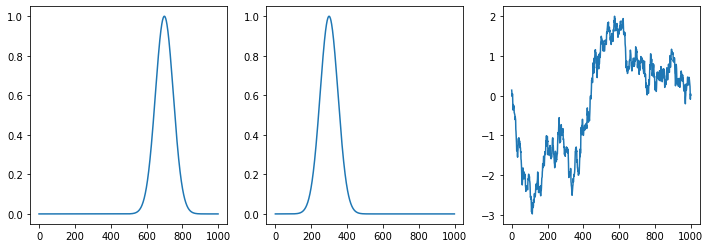

In [15]:
plt.figure(1, figsize=(12,4))

plt.subplot(131)
plt.plot(fi[:, 0])
plt.subplot(132)
plt.plot(fi[:, 1])
plt.subplot(133)
plt.plot(fi[:, 2])

## Plot the inputs

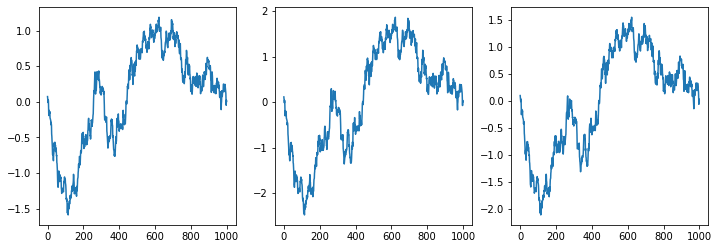

In [16]:
plt.figure(1, figsize=(12,4))

plt.subplot(131)
plt.plot(data[:, 0])
plt.subplot(132)
plt.plot(data[:, 1])
plt.subplot(133)
plt.plot(data[:, 2])

## Apply $\texttt{FastICA}$

In [17]:
ica = FastICA(n_components=n, algorithm='deflation', max_iter=100, tol=1e-4, fun='cube')
sc = ica.fit_transform(data)

ica = FastICA(n_components=n, algorithm='deflation', max_iter=100, tol=1e-4, fun='logcosh')
sl = ica.fit_transform(data)

## Plot extracted signals

/home/jaafar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/jaafar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/jaafar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

Text(0.5, 1.0, 'Negentropy')

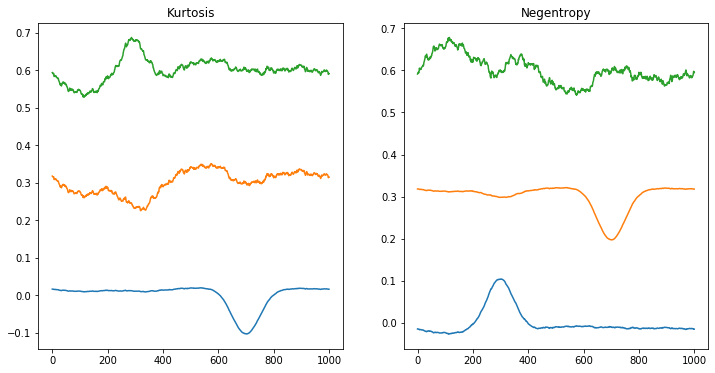

In [18]:
plt.figure(figsize=(12, 6))

for i in range(n):
    plt.subplot(121)
    plt.plot(sc[:, i]+.3*i)
    plt.subplot(122)
    plt.plot(sl[:,i]+.3*i)

plt.subplot(121)
plt.title('Kurtosis')

plt.subplot(122)
plt.title('Negentropy')